<a href="https://colab.research.google.com/github/George-Okello/Language_Switching/blob/main/Language_Switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install transformers datasets sentencepiece
!pip install matplotlib seaborn scikit-learn


In [ ]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
try:
    print("=== Loading UN Parallel Corpus ===")
    dataset = load_dataset("un_pc", "en-es")
    print(f"✅ Dataset loaded successfully!")
    print(f"Available splits: {list(dataset.keys())}")
    print(f"Number of examples: {len(dataset['train'])}")
    print("\nSample examples:")
    for i in range(3):
        example = dataset['train'][i]
        print(f"  {i+1}. EN: {example['translation']['en']}")
        print(f"     ES: {example['translation']['es']}")
        print()
except Exception as e:
    print(f"❌ Error: {e}")

print("-" * 60)

=== Loading UN Parallel Corpus ===


Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

✅ Dataset loaded successfully!
Available splits: ['train']
Number of examples: 25227004

Sample examples:
  1. EN: Distr.
     ES: Distr.

  2. EN: GENERAL
     ES: GENERAL

  3. EN: UNEP/OzL.Pro.3/11
     ES: UNEP/OzL.Pro.3/11

------------------------------------------------------------


In [ ]:
def extract_parallel_sentences(dataset, lang1="en", lang2="es", max_samples=1000):
    sents_lang1, sents_lang2 = [], []
    for i in range(min(max_samples, len(dataset["train"]))):
        try:
            sents_lang1.append(dataset["train"][i]["translation"][lang1])
            sents_lang2.append(dataset["train"][i]["translation"][lang2])
        except KeyError:
            continue
    return sents_lang1, sents_lang2

en_sentences, es_sentences = extract_parallel_sentences(dataset)


In [ ]:
# Show sample aligned sentences
print("=== Sample Aligned Sentences (English ↔ Spanish) ===\n")
for i in range(10):
    print(f"{i+1}. EN: {en_sentences[i]}")
    print(f"   ES: {es_sentences[i]}")
    print()


=== Sample Aligned Sentences (English ↔ Spanish) ===

1. EN: Distr.
   ES: Distr.

2. EN: GENERAL
   ES: GENERAL

3. EN: UNEP/OzL.Pro.3/11
   ES: UNEP/OzL.Pro.3/11

4. EN: 21 June 1991
   ES: 21 de junio de 1991

5. EN: ORIGINAL: ENGLISH
   ES: Original: INGLES

6. EN: THIRD MEETING OF THE PARTIES TO THE
   ES: TERCERA REUNION DE LAS PARTES EN EL PROTOCOLO

7. EN: MONTREAL PROTOCOL ON SUBSTANCES
   ES: DE MONTREAL RELATIVO A LAS SUSTANCIAS

8. EN: THAT DEPLETE THE OZONE LAYER
   ES: QUE AGOTAN LA CAPA DE OZONO

9. EN: Nairobi, 1921 June 1991
   ES: Nairobi, 19 a 21 de junio de 1991

10. EN: REPORT OF THE THIRD MEETING OF THE PARTIES
   ES: INFORME DE LA TERCERA REUNION DE LAS PARTES EN EL



In [ ]:
def clean_and_extract(dataset, lang1="en", lang2="es", max_samples=1000, min_len=5, max_len=30):
    sents_lang1, sents_lang2 = [], []
    seen = set()

    for i in range(len(dataset["train"])):
        try:
            sent1 = dataset["train"][i]["translation"][lang1].strip()
            sent2 = dataset["train"][i]["translation"][lang2].strip()

            # Skip if empty or already seen
            if not sent1 or not sent2:
                continue
            if (sent1, sent2) in seen:
                continue

            # Token count filtering
            if not (min_len <= len(sent1.split()) <= max_len):
                continue
            if not (min_len <= len(sent2.split()) <= max_len):
                continue

            # Store and mark as seen
            sents_lang1.append(sent1)
            sents_lang2.append(sent2)
            seen.add((sent1, sent2))

            # Stop if max reached
            if len(sents_lang1) >= max_samples:
                break

        except (KeyError, AttributeError):
            continue

    return sents_lang1, sents_lang2


In [ ]:
en_sentences, es_sentences = clean_and_extract(dataset, lang1="en", lang2="es", max_samples=1000)


In [ ]:
print("=== Cleaned Aligned Sentence Pairs (EN ↔ ES) ===\n")
for i in range(5):
    print(f"{i+1}. EN: {en_sentences[i]}")
    print(f"   ES: {es_sentences[i]}")
    print()


=== Cleaned Aligned Sentence Pairs (EN ↔ ES) ===

1. EN: THIRD MEETING OF THE PARTIES TO THE
   ES: TERCERA REUNION DE LAS PARTES EN EL PROTOCOLO

2. EN: THAT DEPLETE THE OZONE LAYER
   ES: QUE AGOTAN LA CAPA DE OZONO

3. EN: REPORT OF THE THIRD MEETING OF THE PARTIES
   ES: INFORME DE LA TERCERA REUNION DE LAS PARTES EN EL

4. EN: TO THE MONTREAL PROTOCOL ON SUBSTANCES
   ES: PROTOCOLO DE MONTREAL RELATIVO A LAS SUSTANCIAS INTRODUCCION

5. EN: I. OPENING OF THE MEETING
   ES: I. APERTURA DE LA REUNION



In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load multilingual BERT
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
import torch

def get_cls_embedding(text, tokenizer, model):
    device = model.device  # Automatically uses GPU if model is on GPU

    # Tokenize and move inputs to the same device as the model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True).to(device)

    # Run model inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract CLS token embedding and move to CPU
    cls_embedding = outputs.last_hidden_state[0, 0, :].detach().cpu().numpy()

    return cls_embedding


In [ ]:
embeddings = []
langs = []
labels = []

sample_size = 300  # For t-SNE efficiency (you can increase later)

for en, es in zip(en_sentences[:sample_size], es_sentences[:sample_size]):
    emb_en = get_cls_embedding(en, tokenizer, model)
    emb_es = get_cls_embedding(es, tokenizer, model)

    embeddings.append(emb_en)
    langs.append("EN")
    labels.append(en)

    embeddings.append(emb_es)
    langs.append("ES")
    labels.append(es)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
import numpy as np

embeddings = np.array(embeddings)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)


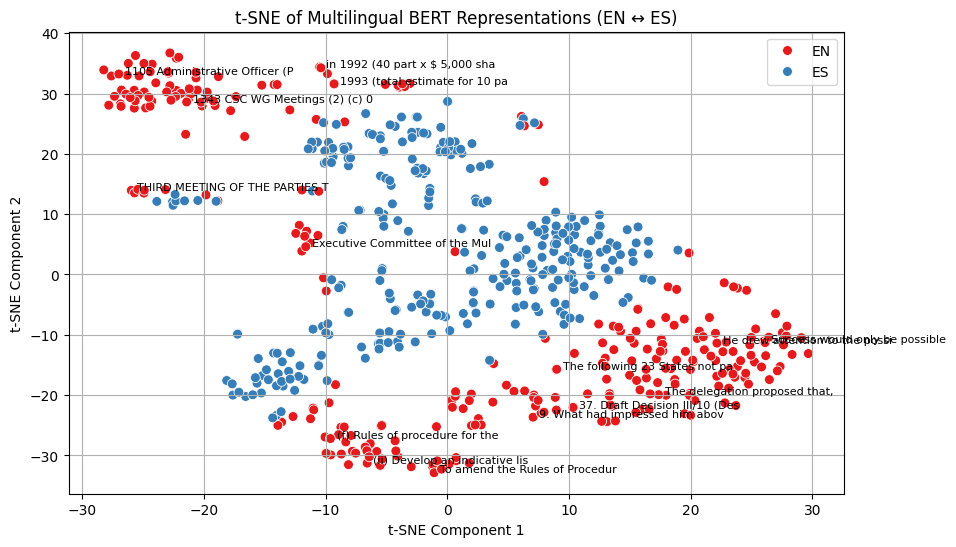

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=langs, palette="Set1", s=50)

# Optionally annotate a few sentences
for i in range(0, len(labels), 40):  # Show fewer annotations
    plt.text(reduced_embeddings[i, 0]+0.5, reduced_embeddings[i, 1], labels[i][:30], fontsize=8)

plt.title("t-SNE of Multilingual BERT Representations (EN ↔ ES)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
idx = 42  # Choose any index within range
sent_en = en_sentences[idx]
sent_es = es_sentences[idx]

print(f"EN: {sent_en}")
print(f"ES: {sent_es}")


EN: The following other organizations were represented:
ES: Estuvieron representadas además las organizaciones siguientes:


In [ ]:
vec_en = get_cls_embedding(sent_en, tokenizer, model)
vec_es = get_cls_embedding(sent_es, tokenizer, model)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
num_points = 10
interpolated_vecs = [
    (1 - alpha) * vec_en + alpha * vec_es
    for alpha in np.linspace(0, 1, num_points)
]


In [ ]:
all_vectors = [vec_en] + interpolated_vecs[1:-1] + [vec_es]
labels_interp = ["EN"] + [f"Step {i}" for i in range(1, num_points - 1)] + ["ES"]


In [ ]:
tsne_interp = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_interp = tsne_interp.fit_transform(np.array(all_vectors))


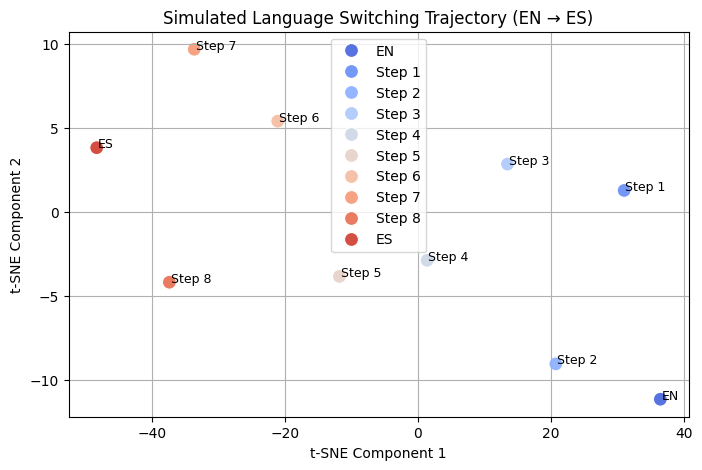

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=reduced_interp[:, 0], y=reduced_interp[:, 1], hue=labels_interp, palette="coolwarm", s=100)

# Annotate each point with its step
for i, label in enumerate(labels_interp):
    plt.text(reduced_interp[i, 0]+0.2, reduced_interp[i, 1], label, fontsize=9)

plt.title("Simulated Language Switching Trajectory (EN → ES)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


In [ ]:
from scipy.spatial.distance import cosine

print("Cosine similarity with EN:")
for i, vec in enumerate(interpolated_vecs):
    print(f"  Step {i}: {1 - cosine(vec, vec_en):.4f}")

print("\nCosine similarity with ES:")
for i, vec in enumerate(interpolated_vecs):
    print(f"  Step {i}: {1 - cosine(vec, vec_es):.4f}")


Cosine similarity with EN:
  Step 0: 1.0000
  Step 1: 0.9987
  Step 2: 0.9945
  Step 3: 0.9874
  Step 4: 0.9773
  Step 5: 0.9642
  Step 6: 0.9483
  Step 7: 0.9296
  Step 8: 0.9086
  Step 9: 0.8854

Cosine similarity with ES:
  Step 0: 0.8854
  Step 1: 0.9083
  Step 2: 0.9292
  Step 3: 0.9478
  Step 4: 0.9638
  Step 5: 0.9769
  Step 6: 0.9871
  Step 7: 0.9944
  Step 8: 0.9986
  Step 9: 1.0000


In [ ]:
def load_aligned_sentences(file_en, file_es, max_pairs=100):
    pairs = []
    with open(file_en, 'r', encoding='utf-8') as f_en, open(file_es, 'r', encoding='utf-8') as f_es:
        for i, (en_line, es_line) in enumerate(zip(f_en, f_es)):
            en = en_line.strip()
            es = es_line.strip()
            if en and es:
                pairs.append((en, es))
            if len(pairs) >= max_pairs:
                break
    return pairs


In [ ]:
# Interpolation function
def interpolate_vectors(v1, v2, steps=10):
    return [(1 - alpha) * v1 + alpha * v2 for alpha in np.linspace(0, 1, steps)]

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def analyze_switching_paths_from_lists(en_sentences, es_sentences, steps=10, max_pairs=100):
    sentence_pairs = list(zip(en_sentences, es_sentences))[:max_pairs]

    similarity_en_all = []
    similarity_es_all = []

    for en_sent, es_sent in sentence_pairs:
        en_vec = model.encode(en_sent)
        es_vec = model.encode(es_sent)
        path_vecs = interpolate_vectors(en_vec, es_vec, steps=steps)

        sim_en = [cosine_similarity([v], [en_vec])[0][0] for v in path_vecs]
        sim_es = [cosine_similarity([v], [es_vec])[0][0] for v in path_vecs]

        similarity_en_all.append(sim_en)
        similarity_es_all.append(sim_es)

    mean_sim_en = np.mean(similarity_en_all, axis=0)
    mean_sim_es = np.mean(similarity_es_all, axis=0)

    alpha_values = np.linspace(0, 1, steps)
    plt.plot(alpha_values, mean_sim_en, label="Similarity to English")
    plt.plot(alpha_values, mean_sim_es, label="Similarity to Spanish")
    plt.title("Averaged Switching Path Across Sentence Pairs")
    plt.xlabel("Interpolation α")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

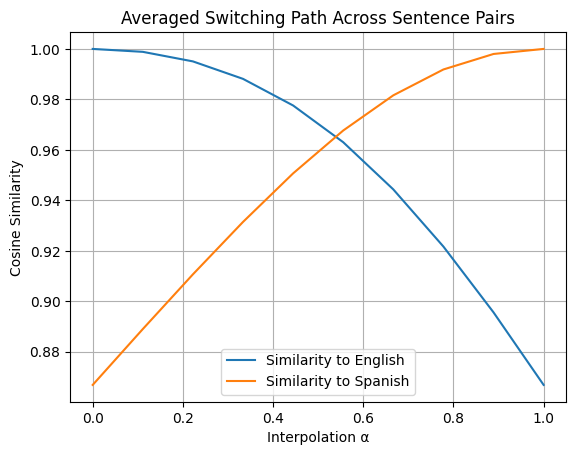

In [ ]:
analyze_switching_paths_from_lists(en_sentences, es_sentences, steps=10, max_pairs=100)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_switching_paths(en_sentences, es_sentences, steps=10, max_pairs=10):
    fig, ax = plt.subplots()
    alpha_values = np.linspace(0, 1, steps)
    line1, = ax.plot([], [], 'b-', label="Similarity to English")
    line2, = ax.plot([], [], 'r--', label="Similarity to Spanish")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Interpolation α")
    ax.set_ylabel("Cosine Similarity")
    ax.set_title("Animated Switching Path Between EN and ES")
    ax.legend()
    ax.grid(True)

    sentence_pairs = list(zip(en_sentences, es_sentences))[:max_pairs]
    sim_data = []

    for en_sent, es_sent in sentence_pairs:
        en_vec = model.encode(en_sent)
        es_vec = model.encode(es_sent)
        path_vecs = interpolate_vectors(en_vec, es_vec, steps=steps)
        sim_en = [cosine_similarity([v], [en_vec])[0][0] for v in path_vecs]
        sim_es = [cosine_similarity([v], [es_vec])[0][0] for v in path_vecs]
        sim_data.append((sim_en, sim_es))

    def update(i):
        sim_en, sim_es = sim_data[i]
        line1.set_data(alpha_values, sim_en)
        line2.set_data(alpha_values, sim_es)
        ax.set_title(f"Sentence {i+1}/{len(sim_data)}")
        return line1, line2

    ani = animation.FuncAnimation(fig, update, frames=len(sim_data), blit=True, repeat=False, interval=1500)
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

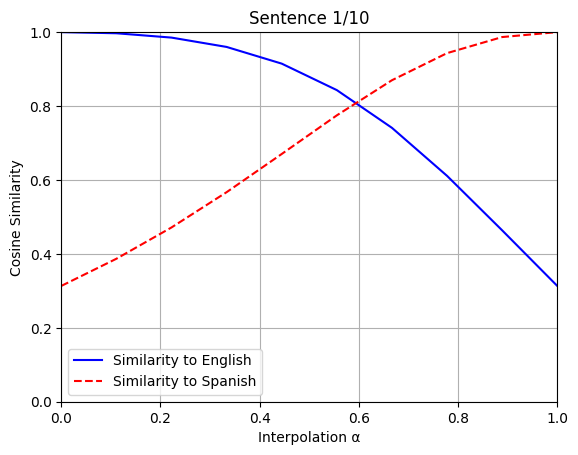

In [ ]:
animate_switching_paths(en_sentences, es_sentences, steps=10, max_pairs=10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def simulate_control_signal(interpolated_vectors, en_emb, es_emb):
    # Cosine similarity to source (EN) and target (ES)
    sim_to_en = [cosine_similarity(v.reshape(1, -1), en_emb.reshape(1, -1))[0][0] for v in interpolated_vectors]
    sim_to_es = [cosine_similarity(v.reshape(1, -1), es_emb.reshape(1, -1))[0][0] for v in interpolated_vectors]

    # Control signal: rate of change in similarity
    control_signal = np.abs(np.gradient(sim_to_en)) + np.abs(np.gradient(sim_to_es))

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax[0].plot(sim_to_en, label="Similarity to EN", color="blue")
    ax[0].plot(sim_to_es, label="Similarity to ES", color="green")
    ax[0].set_ylabel("Cosine Similarity")
    ax[0].legend()
    ax[0].set_title("Language Switching Path")

    ax[1].plot(control_signal, color="red")
    ax[1].set_xlabel("Interpolation Step")
    ax[1].set_ylabel("Simulated ACC Signal")
    ax[1].set_title("Simulated Cognitive Control Demand")

    plt.tight_layout()
    plt.show()

    return sim_to_en, sim_to_es, control_signal




In [ ]:
en_emb = model.encode(en_sentences)
es_emb = model.encode(es_sentences)
interpolated_vectors = interpolate_vectors(en_emb, es_emb, steps=20)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


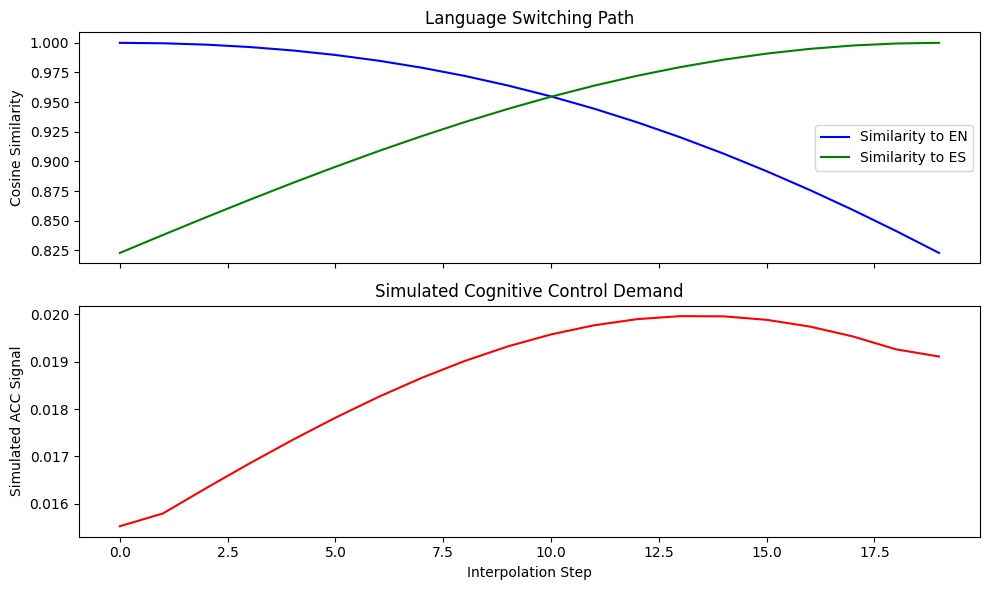

In [ ]:
sim_to_en, sim_to_es, control = simulate_control_signal(interpolated_vectors, en_emb, es_emb)


In [ ]:
def interpolate_embeddings(start_emb, end_emb, steps=50):
    return np.array([start_emb + (end_emb - start_emb) * t for t in np.linspace(0, 1, steps)])

def simulate_code_switching_control_signal(en_emb, es_emb, steps=50):
    # Interpolation: EN -> ES and then ES -> EN
    to_spanish = interpolate_embeddings(en_emb, es_emb, steps)
    to_english = interpolate_embeddings(es_emb, en_emb, steps)

    # Full back-and-forth path
    code_switched_path = np.concatenate([to_spanish, to_english], axis=0)

    # Compute cosine similarities
    sim_to_en = [cosine_similarity(v.reshape(1, -1), en_emb.reshape(1, -1))[0][0] for v in code_switched_path]
    sim_to_es = [cosine_similarity(v.reshape(1, -1), es_emb.reshape(1, -1))[0][0] for v in code_switched_path]

    # Simulated control signal (ACC-like)
    control_signal = np.abs(np.gradient(sim_to_en)) + np.abs(np.gradient(sim_to_es))

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax[0].plot(sim_to_en, label="Similarity to English", color="blue")
    ax[0].plot(sim_to_es, label="Similarity to Spanish", color="green")
    ax[0].set_ylabel("Cosine Similarity")
    ax[0].legend()
    ax[0].set_title("Code-Switching Path (EN → ES → EN)")

    ax[1].plot(control_signal, color="red")
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel("Simulated ACC Control Signal")
    ax[1].set_title("Simulated Cognitive Control Demand")

    plt.tight_layout()
    plt.show()

    return sim_to_en, sim_to_es, control_signal


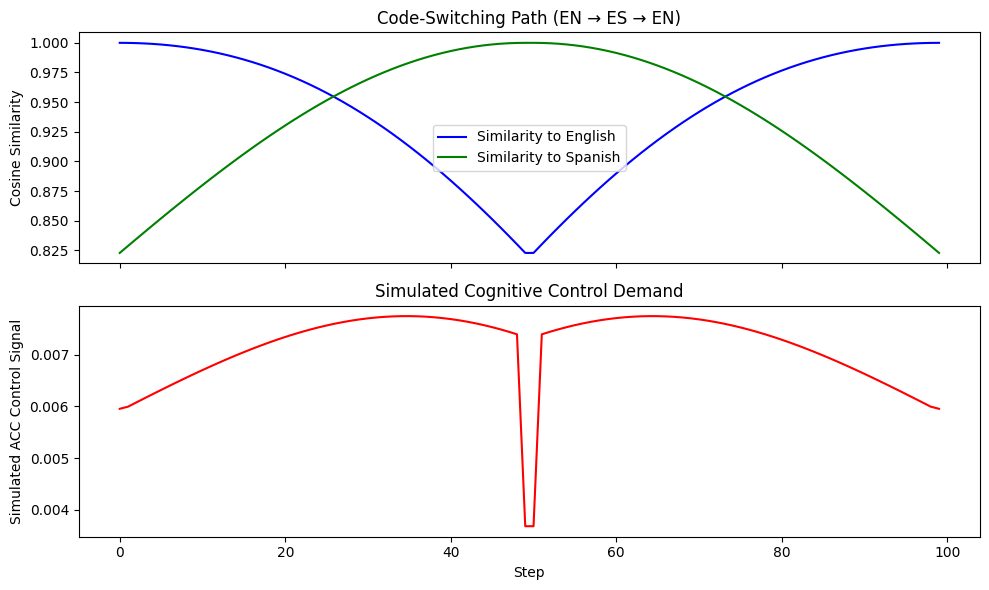

([np.float64(0.9999999999999959),
  np.float64(0.9999452659053826),
  np.float64(0.9997787500114255),
  np.float64(0.9994969846371391),
  np.float64(0.99909651220516),
  np.float64(0.9985738936820362),
  np.float64(0.9979257174481801),
  np.float64(0.9971486085802527),
  np.float64(0.9962392385244285),
  np.float64(0.9951943351344504),
  np.float64(0.994010693043773),
  np.float64(0.9926851843362678),
  np.float64(0.9912147694752281),
  np.float64(0.9895965084455822),
  np.float64(0.9878275720595315),
  np.float64(0.9859052533712079),
  np.float64(0.9838269791416141),
  np.float64(0.981590321290979),
  np.float64(0.9791930082719424),
  np.float64(0.9766329362936725),
  np.float64(0.9739081803241969),
  np.float64(0.9710170047960568),
  np.float64(0.9679578739387843),
  np.float64(0.9647294616608821),
  np.float64(0.9613306609038874),
  np.float64(0.9577605923918805),
  np.float64(0.9540186127013559),
  np.float64(0.9501043215789069),
  np.float64(0.9460175684375449),
  np.float64(0.941

In [ ]:
# Example usage if you already have the sentence embeddings:
simulate_code_switching_control_signal(en_emb, es_emb)


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


In [ ]:
def get_control_signals(en_sentences, es_sentences, model, steps=5):
    """
    Compute simulated control signals for each English-Spanish sentence pair.

    Args:
        en_sentences (List[str]): English sentences.
        es_sentences (List[str]): Spanish sentences.
        model (SentenceTransformer): Sentence embedding model.
        steps (int): Number of interpolation steps.

    Returns:
        np.ndarray: Array of control signal curves for each sentence pair.
    """
    control_signals = []

    for en, es in zip(en_sentences, es_sentences):
        try:
            # Encode English and Spanish sentences to vector embeddings
            en_emb = model.encode(en, convert_to_numpy=True)
            es_emb = model.encode(es, convert_to_numpy=True)

            # Simulate control signal using interpolated embeddings
            _, _, control = simulate_code_switching_control_signal(en_emb, es_emb, steps=steps)

            # Store the control signal
            control_signals.append(control)

        except Exception as e:
            print(f"⚠️ Skipped pair [{en[:30]}... | {es[:30]}...] due to error: {e}")
            continue

    return np.array(control_signals)


In [ ]:
control_signals = get_control_signals(en_sentences, es_sentences, model, steps=5)
